In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
import sys

import hydra
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torchaudio
import lightning.pytorch as pl
from scipy.stats import gaussian_kde
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import Audio, display

from pathlib import Path
from egaznepy.visualize import apply_plot_style
from src.data.mocha_timit_datamodule import MTIMITDataModule
from src.models.pitch_module import PitchModule
from src.models.components.metrics import RCAMetric
from torchmetrics.classification.accuracy import Accuracy



apply_plot_style(0.9)
plt.rcParams['text.usetex'] = False

root_dir = Path(globals()['_dh'][0]).parent
print(root_dir)
import os
os.chdir(root_dir)
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

config_path_predict_cc = 'logs/train/runs/2024-07-23_15-17-46_cc_timit_with_reduced_cc/.hydra/config.yaml'
ckpt_path_cc = 'logs/train/runs/2024-07-23_15-17-46_cc_timit_with_reduced_cc/checkpoints/epoch_010.ckpt'

config_path_predict_if = 'logs/train/runs/2024-07-25_11-26-01_if_timit_with_reduced_cc/.hydra/config.yaml'
ckpt_path_if = 'logs/train/runs/2024-07-25_11-26-01_if_timit_with_reduced_cc/checkpoints/epoch_094.ckpt'



config_path_predict_joint = 'logs/train/runs/2024-07-23_13-52-53_joint_timit_with_reduced_cc_dim/.hydra/config.yaml'
ckpt_path_joint = 'logs/train/runs/2024-07-23_13-52-53_joint_timit_with_reduced_cc_dim/checkpoints/epoch_078.ckpt'


/dataHDD/chsaikeerthi/2024-chirumamilla


In [3]:

config_predict_cc = OmegaConf.load(config_path_predict_cc)
datamodule = hydra.utils.instantiate(config_predict_cc.data, slice=False, batch_size=4)
pitch_module_cc: PitchModule = hydra.utils.instantiate(config_predict_cc.model)

config_predict_if = OmegaConf.load(config_path_predict_if)
pitch_module_if: PitchModule = hydra.utils.instantiate(config_predict_if.model)

config_predict_joint = OmegaConf.load(config_path_predict_joint)
pitch_module_joint: PitchModule = hydra.utils.instantiate(config_predict_joint.model)

del config_predict_if.trainer.default_root_dir
del config_predict_cc.trainer.default_root_dir
del config_predict_joint.trainer.default_root_dir

config_predict_cc.trainer.limit_predict_batches = 1
config_predict_if.trainer.limit_predict_batches = 1
config_predict_joint.trainer.limit_predict_batches = 1


trainer = hydra.utils.instantiate(config_predict_cc.trainer) 
arr_predict_cc = trainer.predict(model=pitch_module_cc, datamodule=datamodule, ckpt_path=ckpt_path_cc)

trainer = hydra.utils.instantiate(config_predict_if.trainer) 
arr_predict_if = trainer.predict(model=pitch_module_if, datamodule=datamodule, ckpt_path=ckpt_path_if)

trainer = hydra.utils.instantiate(config_predict_joint.trainer) 
arr_predict_joint = trainer.predict(model=pitch_module_joint, datamodule=datamodule, ckpt_path=ckpt_path_joint)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.


Preparing data...
Data directory: data/
Should implement the code to check if data is already downloaded and extracted for TIMIT


Restoring states from the checkpoint path at logs/train/runs/2024-07-23_15-17-46_cc_timit_with_reduced_cc/checkpoints/epoch_010.ckpt


Data prepared successfully.
Data folder: data/TIMIT
Train set length: 5039
Validation set length: 630
Test set length: 629
Data set-up done successfully.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at logs/train/runs/2024-07-23_15-17-46_cc_timit_with_reduced_cc/checkpoints/epoch_010.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.


Preparing data...
Data directory: data/
Should implement the code to check if data is already downloaded and extracted for TIMIT
Data prepared successfully.
Data folder: data/TIMIT


Restoring states from the checkpoint path at logs/train/runs/2024-07-25_11-26-01_if_timit_with_reduced_cc/checkpoints/epoch_094.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at logs/train/runs/2024-07-25_11-26-01_if_timit_with_reduced_cc/checkpoints/epoch_094.ckpt


Data set-up done successfully.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.


Preparing data...
Data directory: data/
Should implement the code to check if data is already downloaded and extracted for TIMIT


Restoring states from the checkpoint path at logs/train/runs/2024-07-23_13-52-53_joint_timit_with_reduced_cc_dim/checkpoints/epoch_078.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at logs/train/runs/2024-07-23_13-52-53_joint_timit_with_reduced_cc_dim/checkpoints/epoch_078.ckpt


Data prepared successfully.
Data folder: data/TIMIT
Data set-up done successfully.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [12]:
# Extract the first 4 elements - our model

pitches_predicted_cc = arr_predict_cc[0][0:4]
pitches_predicted_if = arr_predict_if[0][0:4]
pitches_predicted_joint = arr_predict_joint[0][0:4]


# gt
corresponding_data = next(iter(datamodule.test_dataloader()))
corresponding_audio = corresponding_data[0][0:4]
pitches_gt = corresponding_data[1][0:4]
probs_gt = corresponding_data[2][0:4]
mask_gt = probs_gt > 0.3
pitches_gt = pitch_module_cc.decoder.idx_pitch[pitches_gt.argmax(dim=-1)]
#pitches_gt = pitches_gt * mask_gt


print("pitches_shape",pitches_gt.shape)
print("probs_shape",probs_gt.shape)
print("cc predictions", pitches_predicted_cc.shape)
print("cc predictions max", pitches_predicted_cc.max())

pitches_shape torch.Size([4, 381])
probs_shape torch.Size([4, 381])
cc predictions torch.Size([4, 381])
cc predictions max tensor(122.6030)


RC Accuracy for CC model: 0.29256966710090637


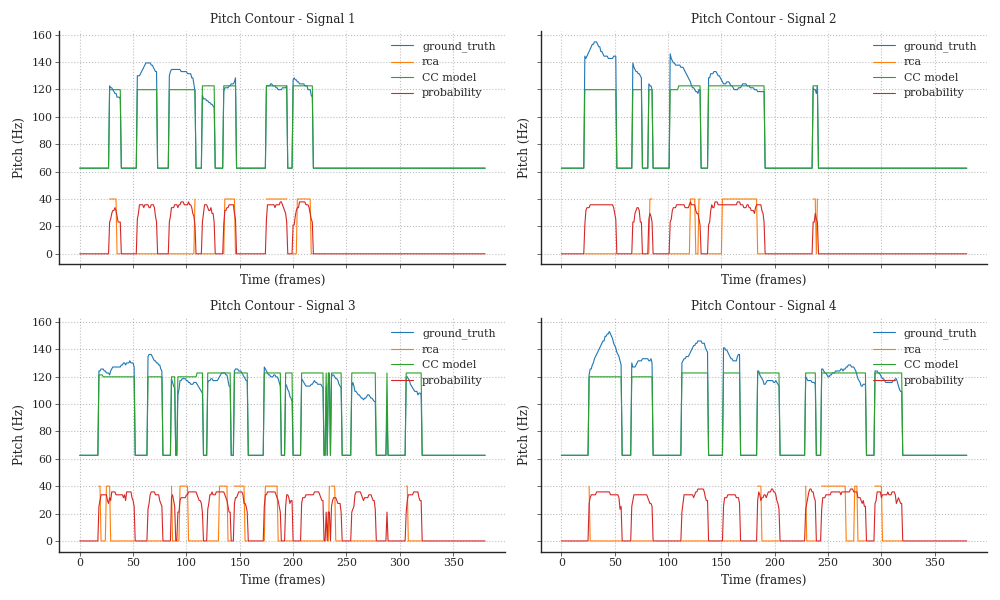

pitches_pridict shape_cc torch.Size([4, 381]) 
ground truth shape torch.Size([4, 381]) 
ground_truth min tensor(62.5000) 
ground truth max tensor(154.6697) 
predict pitched min cc tensor(62.5000) 
predict pitched max cc  tensor(122.6030) 
pitches_pridict shape torch.Size([4, 381]) 
predict pitched min  tensor(62.5000) 
predict pitched max  tensor(154.6697) 
pitches_pridict shape torch.Size([4, 381]) 
predict pitched min  tensor(62.5000) 
predict pitched max  tensor(158.3054) 
result_max tensor(nan) 
result_min tensor(nan)


RC Accuracy for IF model: 0.9442724585533142


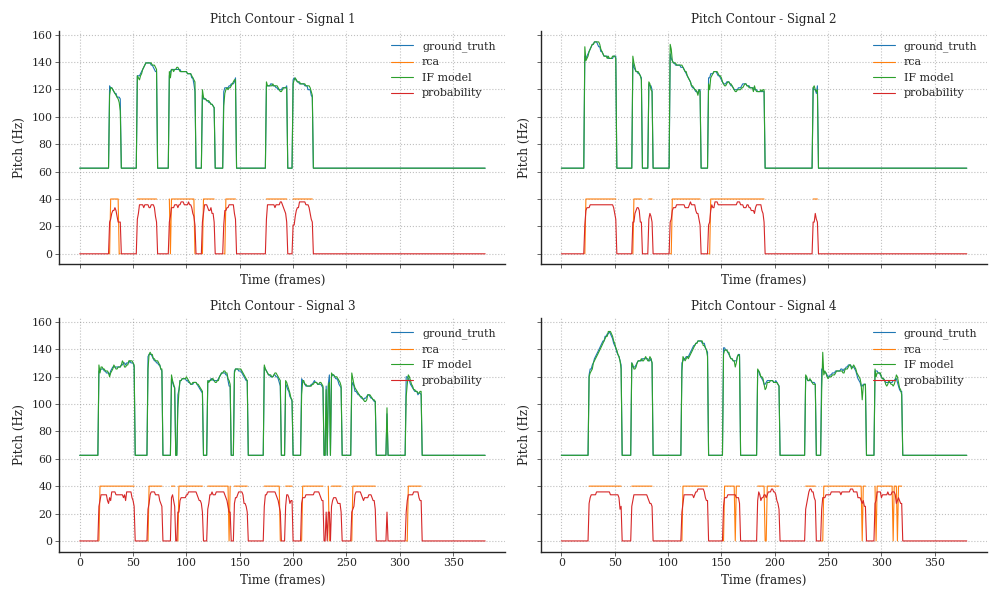

pitches_pridict shape_cc torch.Size([4, 381]) 
ground truth shape torch.Size([4, 381]) 
ground_truth min tensor(62.5000) 
ground truth max tensor(154.6697) 
predict pitched min cc tensor(62.5000) 
predict pitched max cc  tensor(122.6030) 
pitches_pridict shape torch.Size([4, 381]) 
predict pitched min  tensor(62.5000) 
predict pitched max  tensor(154.6697) 
pitches_pridict shape torch.Size([4, 381]) 
predict pitched min  tensor(62.5000) 
predict pitched max  tensor(158.3054) 
result_max tensor(nan) 
result_min tensor(nan)


RC Accuracy for Joint: 0.9411764740943909


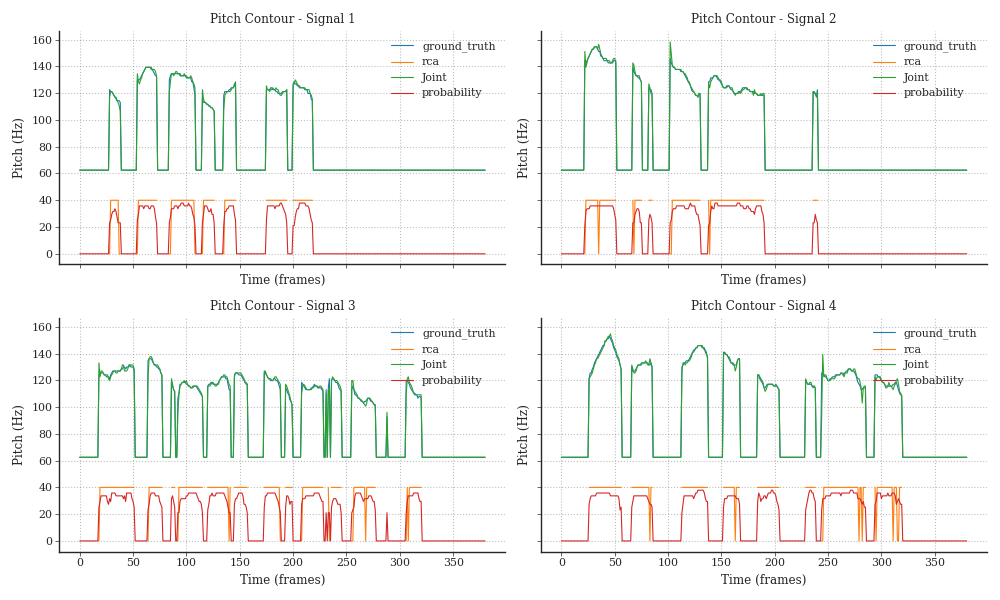

pitches_pridict shape_cc torch.Size([4, 381]) 
ground truth shape torch.Size([4, 381]) 
ground_truth min tensor(62.5000) 
ground truth max tensor(154.6697) 
predict pitched min cc tensor(62.5000) 
predict pitched max cc  tensor(122.6030) 
pitches_pridict shape torch.Size([4, 381]) 
predict pitched min  tensor(62.5000) 
predict pitched max  tensor(154.6697) 
pitches_pridict shape torch.Size([4, 381]) 
predict pitched min  tensor(62.5000) 
predict pitched max  tensor(158.3054) 
result_max tensor(nan) 
result_min tensor(nan)


In [6]:
def plot_pitch_line_subplots(**model_pitches):
    num_signals = len(list(model_pitches.values())[0])
    fig, axs = plt.subplots(num_signals//2, num_signals//2, figsize=(5*num_signals//2, 3*num_signals//2), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for model_name, pitches in model_pitches.items():
        for i, pitch in enumerate(pitches):
            axs[i].plot(pitch, label=model_name)
            axs[i].set_title(f'Pitch Contour - Signal {i + 1}')
            axs[i].set_xlabel('Time (frames)')
            axs[i].set_ylabel('Pitch (Hz)')
            axs[i].grid(True)
            axs[i].legend()      
    
    plt.tight_layout()
    plt.show()

    print("pitches_pridict shape_cc",pitches_predicted_cc.shape,
      "\nground truth shape" ,pitches_gt.shape,
      "\nground_truth min", pitches_gt.min(),
      "\nground truth max", pitches_gt.max(),
      "\npredict pitched min cc" ,pitches_predicted_cc.min(),
      "\npredict pitched max cc ", pitches_predicted_cc.max(),
      "\npitches_pridict shape",pitches_predicted_if.shape,
      "\npredict pitched min " ,pitches_predicted_if.min(),
      "\npredict pitched max ", pitches_predicted_if.max(),
      "\npitches_pridict shape",pitches_predicted_joint.shape,
      "\npredict pitched min " ,pitches_predicted_joint.min(),
      "\npredict pitched max ", pitches_predicted_joint.max(),
      "\nresult_max",result.max(),
        "\nresult_min",result.min()
      )

for key, eval_data in {'CC model': pitches_predicted_cc,'IF model': pitches_predicted_if, 'Joint' : pitches_predicted_joint }.items():
    pitches = eval_data * mask_gt
    pitches = torch.where(pitches == 0, torch.tensor(62.5), pitches)

    rca = RCAMetric(test_mode=True)
    out, mask = rca.compute_rca_per_frame(pitches, pitches_gt, probs_gt)
    metric = rca(pitches, pitches_gt, probs_gt)

    result = torch.where(out, torch.tensor(40.0), torch.tensor(0))
    result = torch.where(mask, result, torch.nan)
    torch.set_printoptions(threshold=torch.inf)

   
    print(f'RC Accuracy for {key}: {metric}')
    

    # Plotting each of the first 4 elements
    #fig, axs = plt.subplots(4, 1, figsize=(10, 8))
    plot_pitch_line_subplots(ground_truth=pitches_gt, rca=result, **{key: eval_data}, probability=probs_gt*40)
    
    for audio in corresponding_audio:
        display(Audio(audio.squeeze().numpy(), rate=16000))
    